# MNIST Dataset

In [9]:
import numpy as np

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [5]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

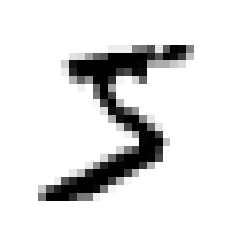

In [6]:
plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [7]:
y[0]

'5'

Label is a string - so we need to convert that to an integer (as most ML algorithms expect numbers)

In [10]:
y = y.astype(np.uint8)

In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Let's train a simple classifier, a '5 detector' - which distinguishes only between 5 and not-5

In [13]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [12]:
from sklearn.linear_model import SGDClassifier

In [14]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [15]:
sgd_clf.predict([some_digit])

array([ True])

##  Performance measures

### Measuring accuracy using cross-validation

K-fold cross-validation means splitting the training set into K folds, then making predictions and evaluating them on each fols using a model trained on the remaining folds.

In [16]:
from sklearn.model_selection import cross_val_score

In [17]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

More than 90% of accuracy - let's train a not-5 classifier

In [18]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [19]:
never_5_clf = Never5Classifier()

In [20]:
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

Again, more than 90% of accuracy - but let's remember that 5 is only 10% of the dataset, so if the classifier is right on everything but the 5, it's 90% accuracy reported. Meaning that accuracy is not the preferred performance measure for classifiers!

### Confusion matrix

To use the confusion matrix, we need to have a set of predictions so that they can be compared to the actual targets. We can use the <i>cross_val_predict()</i> function for that. It's works the same way as <i>cross_val_score()</i> except that it returns the predictions made on each test fold instead of the evaluation scores.

In [22]:
from sklearn.model_selection import cross_val_predict

In [24]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [25]:
from sklearn.metrics import confusion_matrix

In [34]:
conf_matrix = confusion_matrix(y_train_5, y_train_pred)
conf_matrix

array([[53892,   687],
       [ 1891,  3530]])

53892: <i>true negatives</i>(correctly classified as non-5) - 687: <i>false positives</i>(wrongly classified as 5)

1891: <i>false negatives</i>(wrongly classified as non-5) - 3530: <i>true positives</i>(correctly classified as 5)

With these numbers we can calculate the <i>precision</i> and the <i>recall</i>:

precision = TP / (TP + FP)

recall = TP / (TP + FN) - also called <i>sensitivity</i> or <i>true positive rate</i>

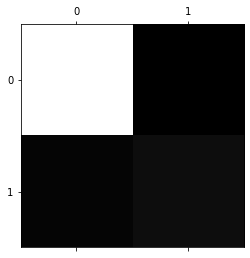

In [36]:
plt.matshow(conf_matrix, cmap=plt.cm.gray)
plt.show()

### Precision and recall

In [27]:
from sklearn.metrics import precision_score, recall_score

In [28]:
precision_score(y_train_5, y_train_pred) 

0.8370879772350012

When the 5-detector claims it's a 5, it's only correct 83.7% of the cases

In [29]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

 And on top of that, it only detects 65% of the 5s.
 
 We can combine both metrics into a single metric called <i>F1 Score</i>

In [31]:
from sklearn.metrics import f1_score

In [32]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### Precision/recall trade-off

Increasing precision reduces recall, and vice versa - it's called the <i>precision/recall trade-off</i>.

The SGDClassifier makes it classification decision based on a score. Score computed on each instance through a <i>decision function</i>. If the score is greater than a threshold, it assigns the instance to the positive class, else to the negative class.

If you raise the threshold, the precision raises up but the recall goes down - and vice versa.

In [38]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [39]:
threshold = 0

In [41]:
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [42]:
threshold = 8000

In [43]:
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

This simple example shows up that raising the threshold decreases recall. So how to decide which threshold to use? First by getting the scores of all instances by using cross_val_predict() - but specifying that we want the decision scores instead of the predictions

In [45]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [46]:
from sklearn.metrics import precision_recall_curve

In [47]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [51]:
def plot_precision_recall_vs_threshold(precisions, recals, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label='Recall')
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])     

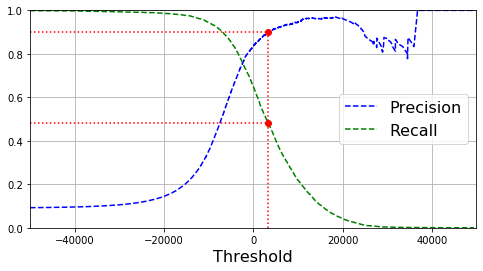

In [54]:
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                                                                        
plt.show()